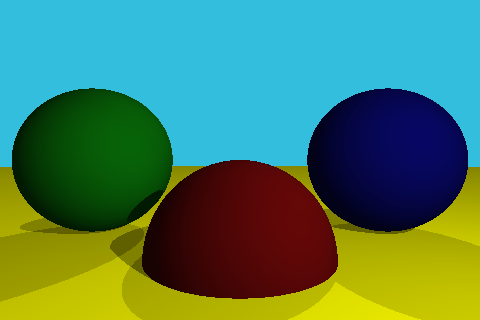

In [14]:
import PIL
import numpy as np
import matplotlib.pyplot as plt
from random import randint
from PIL import Image, ImageDraw

class Light:
    def __init__(self,source_type="point",position=np.array([0.5,0.5,0.5]),intensity=0.5 ):
        self._source_type=source_type
        self._position= np.array(position)
        self._intensity = intensity
    def get_L(self,P):
        if self._source_type == "ambient":
            return np.array((0,0,0))
        elif self._source_type == "point":
            L= self._position-P
        elif self._source_type == "directional":
            L=self._position
        
        L = L/np.linalg.norm(L)
        return np.array(L)
    def ComputeLighting(self,P, N, spher):
        if self._source_type == "ambient":
            return self._intensity
        n_dot_l = np.dot(N, self.get_L(P))
        if self._source_type == "point":
            t_max=1.0
        if self._source_type == "directional":
            t_max=5000
        shadow_t = ClosestIntersection(P,self.get_L(P), 0.001, t_max,spher)
        #print(shadow_t)
        if n_dot_l > 0 and shadow_t==False:
            return self._intensity* n_dot_l
        else:
            return 0





class Sphere:
    def __init__(self, center=np.array([0, 0, 0]), R=1.0, color=np.array([100, 233, 80]), albedo=0):
        self._center = center
        self._R = R
        self._color=np.array(color)
        self.closest_t = np.inf
        self._albedo=albedo

    def ray_inter(self, orig, dire,t_min, t_max):
        self.closest_t = np.inf
        oc = orig - self._center
        k1 = np.dot(dire, dire)
        k2 = 2*np.dot(oc, dire)
        k3 = np.dot(oc, oc) - self._R ** 2
        discr = k2*k2 - 4*k1*k3
        if discr<0:
            return np.inf
        t1 = (-k2 + np.sqrt(discr)) / (2*k1)
        t2 = (-k2 - np.sqrt(discr)) / (2*k1)
        if t1 < self.closest_t and t1>=t_min and t1<=t_max:
            self.closest_t = t1
        if t2 < self.closest_t and t2>=t_min and t2<=t_max:
            self.closest_t = t2
        return self.closest_t

    def get_Norm(self,point):
        N = point - self._center
        N = N/np.linalg.norm(N) 
        return np.array(N)

def ClosestIntersection(orig, dire, t_min, t_max, spher):
    closest_t= np.inf
    closest_sphere = False
    for sphere in spher:
        oc =   orig-sphere._center
        k1 = np.dot(dire, dire)
        k2 = 2*np.dot(oc, dire)
        k3 = np.dot(oc, oc) - sphere._R ** 2
        discr = k2*k2 - 4*k1*k3
        if discr<0:
            continue
        t1 = (-k2 + np.sqrt(discr)) / (2*k1)
        t2 = (-k2 - np.sqrt(discr)) / (2*k1)
        if  t1 < closest_t and t1>=t_min and t1<=t_max:
            closest_t = t1
            closest_sphere = sphere
        if t2 < closest_t and t2>=t_min and t2<=t_max:
            closest_t = t2
            closest_sphere = sphere
    return closest_sphere

def render(width, height, spheres,lights):
    origin=np.array([0, 0, 0])
    fov = np.pi/3.
    Im = np.asarray(Image.new(mode='RGB', size=(width, height), color=(220, 220, 220)))
    Im2 = np.zeros(Im.shape, Im.dtype)
    for i in range(width):
        for j in range(height):
            x =  (2*(i + 0.5)/width  - 1)*np.tan(fov/2.) * width/height
            y = -(2*(j + 0.5)/height - 1)*np.tan(fov/2.)
            direction = np.array([x, y, -1])
            direction=direction/np.linalg.norm(direction)
            direction_n = -direction/np.linalg.norm(direction)
            values = []
            min_t=np.inf
            s_c = False
            for sp in spheres:
                t=sp.ray_inter(origin,direction,0.0,5000)
                if t<min_t:
                    min_t=t
                    s_c=sp
            if s_c:
                sum_dot_intensity = 0
                for a in lights:
                    direct = a.get_L(direction*min_t)
                    sum_dot_intensity+=a.ComputeLighting(direction*min_t,s_c.get_Norm(direction*min_t),spheres)
                    if (a._source_type=="point" or a._source_type=="directional"):
                        if s_c._albedo!=-1:
                            ref=2*s_c.get_Norm(direction*min_t)*np.dot(s_c.get_Norm(direction*min_t),direct)-direct 
                            r_dot_v = np.dot(ref, direction_n)
                            if r_dot_v > 0:
                                sum_dot_intensity += a._intensity*((r_dot_v/(np.linalg.norm(ref)*np.linalg.norm(direction)))**s_c._albedo)
                k = s_c._color*sum_dot_intensity     
                Im2[j][i][0] = 255 if k[0]>255 else k[0]
                Im2[j][i][1] = 255 if k[1]>255 else k[1]
                Im2[j][i][2] = 255 if k[2]>255 else k[2]
            else:
                Im2[j][i] = np.array([50, 190, 220]) # background color 
    display(Image.fromarray(Im2, mode='RGB'))
  
sp1 = Sphere([0, -1,-3], 1,[125, 10, 10],-1)
sp2 = Sphere([-2,0, -4], 1, [10, 125, 10],-1)
sp3 = Sphere([2, 0, -4],1,[10, 10, 125],-1.)
sp4 = Sphere([0, -5001, 0], 5000, [240, 240, 0],0)
light1 = Light(position=(2, 1, 0), intensity=0.6)
light2 = Light("ambient",position=np.array([1,1,1]),intensity=0.2)
light3 = Light("directional", position=(1,4,-4), intensity=0.2)

render(480, 320, (sp3,sp1,sp2,sp4), (light1,light2,light3))
